### Getting Started

In this project, we will analyze a dataset that describes the customer order summary of a Food Delivery business. One of the objectives of this project is to decsribe the variations in the different types of customers that use the app and hence segment the customers into useful categories. Doing so would help the Food Delivery Service structure their services and business strategies(personalization) by making use of the relevant insights.

The dataset can be found in the same directory. The dataset includes features such as:

- **customer_id** - Unique customer Id of a customer
- **first_time** - The first time the customer logged into the app
- **recent_time** - The most recent time when the customer logged into the app
- **avg_dist_from_rest** - Average distance from the restaurant to the customer's delivery address
- **avg_delivery_time** - Average time taken to make a successful order delivery to the customer
- **n_orders, n_orders_in_last_week, n_orders_in_last_4_weeks** - Number of orders made by the customer in last 7 days, last 4 weeks, total respectively
- **amount, amount_in_last_week, amount_in_last_4_weeks** - Amount spent by the customer in last 7 days, last 4 weeks, total respectively

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns
from numpy import log
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from datetime import timedelta
from matplotlib import pyplot
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%matplotlib inline

### Data Cleaning and Wrangling

In [64]:
data = pd.read_excel('./customer_order_summary.xlsx', encoding='latin-1')

In [65]:
data.head()

,customer_id,first_time,recent_time,n_orders,n_orders_in_last_week,n_orders_in_last_4_weeks,amount,amount_in_last_week,amount_in_last_4_weeks,avg_dist_from_rest,avg_delivery_time
0,1269647,2015-06-29 10:57:00,2015-12-10 02:18:00,212,6.0,43.0,138808,4291,26853,1.6,51
1,167631,2015-07-04 15:39:00,2015-12-15 14:42:00,211,8.0,19.0,56404,1925,4177,2.2,42
2,301524,2015-06-26 09:56:00,2015-12-09 20:45:00,189,9.0,33.0,36020,1772,6404,2.5,57
3,1268254,2015-07-01 01:51:00,2015-12-14 01:43:00,184,6.0,37.0,32489,975,7110,3.1,55
4,357161,2015-07-11 18:34:00,2015-12-19 23:26:00,182,4.0,23.0,85150,1738,9958,2.4,36


In [66]:
data.shape

(10000, 11)

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
customer_id                 10000 non-null int64
first_time                  10000 non-null datetime64[ns]
recent_time                 10000 non-null datetime64[ns]
n_orders                    10000 non-null int64
n_orders_in_last_week       1923 non-null float64
n_orders_in_last_4_weeks    4341 non-null float64
amount                      10000 non-null int64
amount_in_last_week         10000 non-null int64
amount_in_last_4_weeks      10000 non-null int64
avg_dist_from_rest          10000 non-null float64
avg_delivery_time           10000 non-null int64
dtypes: datetime64[ns](2), float64(3), int64(6)
memory usage: 859.5 KB


In [68]:
null_columns = data.columns[data.isnull().any()]
null_column_value= data[null_columns].isnull().sum()
not_null_column_value =data[null_columns].notnull().sum()
def percentageOfNullValues():
    for col in null_columns:
        print('column: {} null values :{} null percenatge :{:.2f}'.format(col,null_column_value[col],(null_column_value[col]/(null_column_value[col]+not_null_column_value[col])*100)))
percentageOfNullValues()

column: n_orders_in_last_week null values :8077 null percenatge :80.77
column: n_orders_in_last_4_weeks null values :5659 null percenatge :56.59


In [69]:
data[data['n_orders_in_last_4_weeks'].isnull() == True]['amount_in_last_4_weeks'].mean()

0.0

In [70]:
data[data['n_orders_in_last_week'].isnull() == True]['amount_in_last_week'].mean()

0.0

Since, the average amount spent by customer in last 7 days and last 4 weeks is 0 for all the customer with missing values for column **n_orders_in_last_week and n_orders_in_last_4_weeks,** therefore we can replace the corresponding missing values by 0s

In [71]:
data['n_orders_in_last_4_weeks'].fillna(0,inplace=True)
data['n_orders_in_last_week'].fillna(0,inplace=True)

In [72]:
data.isnull().any()

customer_id                 False
first_time                  False
recent_time                 False
n_orders                    False
n_orders_in_last_week       False
n_orders_in_last_4_weeks    False
amount                      False
amount_in_last_week         False
amount_in_last_4_weeks      False
avg_dist_from_rest          False
avg_delivery_time           False
dtype: bool

In [73]:
data.head()

,customer_id,first_time,recent_time,n_orders,n_orders_in_last_week,n_orders_in_last_4_weeks,amount,amount_in_last_week,amount_in_last_4_weeks,avg_dist_from_rest,avg_delivery_time
0,1269647,2015-06-29 10:57:00,2015-12-10 02:18:00,212,6.0,43.0,138808,4291,26853,1.6,51
1,167631,2015-07-04 15:39:00,2015-12-15 14:42:00,211,8.0,19.0,56404,1925,4177,2.2,42
2,301524,2015-06-26 09:56:00,2015-12-09 20:45:00,189,9.0,33.0,36020,1772,6404,2.5,57
3,1268254,2015-07-01 01:51:00,2015-12-14 01:43:00,184,6.0,37.0,32489,975,7110,3.1,55
4,357161,2015-07-11 18:34:00,2015-12-19 23:26:00,182,4.0,23.0,85150,1738,9958,2.4,36


Now, the values in most of the columns should be positive since number of orders, amount, distance and time cannot be negative. Therefore we do a scan to check if there are any columns with negative values.

In [74]:
data.describe()

,customer_id,n_orders,n_orders_in_last_week,n_orders_in_last_4_weeks,amount,amount_in_last_week,amount_in_last_4_weeks,avg_dist_from_rest,avg_delivery_time
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,6.714023e+05,7.006200,0.333600,1.388100,2253.273600,109.497500,455.491200,2.35620,36.914300
std,3.901880e+05,13.118619,0.910052,3.041842,5136.484499,397.055277,1237.872749,0.97492,13.175413
min,2.800000e+01,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.80000,15.000000
25%,3.365148e+05,1.000000,0.000000,0.000000,279.000000,0.000000,0.000000,1.70000,26.000000
50%,6.683395e+05,2.000000,0.000000,0.000000,688.000000,0.000000,0.000000,2.40000,36.500000
75%,1.005002e+06,7.000000,0.000000,1.000000,2040.000000,0.000000,398.000000,3.02500,47.000000
max,1.355445e+06,212.000000,14.000000,46.000000,138808.000000,10150.000000,26853.000000,5.90000,83.000000


In [75]:
print('range of avg_dist_from_rest [{} , {}]'.format(data['avg_dist_from_rest'].min(),data['avg_dist_from_rest'].max()))

range of avg_dist_from_rest [-0.8 , 5.9]


In [76]:
print('total negative number in avg_dist_from_rest : {}'.format(len(data[data['avg_dist_from_rest']<0])))
print('total zero value in avg_dist_from_rest : {}'.format(len(data[data['avg_dist_from_rest']==0])))
print('total positive number in avg_dist_from_rest : {}'.format(len(data[data['avg_dist_from_rest']>0])))

total negative number in avg_dist_from_rest : 44
total zero value in avg_dist_from_rest : 22
total positive number in avg_dist_from_rest : 9934


In [77]:
print('average delivery time for invalid restaurent distances : {:.2f}'.format\
      (data[data['avg_dist_from_rest']<=0]['avg_delivery_time'].mean()))

print('average delivery time for valid restaurent distances : {:.2f}'.format\
      (data[(data['avg_dist_from_rest'] > 0) & (data['avg_dist_from_rest'] < 1)]['avg_delivery_time'].mean()))

average delivery time for invalid restaurent distances : 33.42
average delivery time for valid restaurent distances : 35.18


Either these 66 values are completely incorrect or there has been an error while recording the values and the negative sign is accidental. Since, we find that the mean **avg_delivery_time(33.42)** of the records with negative **avg_dist_from_rest** values is comparable with the mean **avg_delivery_time(35.18)** of the records that have **avg_dist_from_rest < 1**. Therefore, we can assume the latter and convert negative values to postive values. We shall also drop the records with **avg_distance_from_rest == 0** as that would be invalid.

In [78]:
data['avg_dist_from_rest'] = data['avg_dist_from_rest'].apply(lambda x: abs(x))

In [79]:
data= data[data['avg_dist_from_rest'] > 0.0]
len(data[data['avg_dist_from_rest']<=0])

0

### Feature Engineering

Let's create some new features that could aid our analysis and objective such as:

- **last_order_diff** = no. of days since last order
- **avg_amout_order** = total amount / total no. of orders

In [80]:
data['first_time']=pd.to_datetime(data['first_time'])
data['recent_time']=pd.to_datetime(data['recent_time'])


In [81]:
print('data available range : [{}, {}]'.format(data['first_time'].min(),data['recent_time'].max()))

data available range : [2015-06-05 17:21:00, 2016-01-13 05:54:00]


In [83]:
#let data collected on 
NOW = dt.datetime(2016, 1, 14)
print(NOW)
data['last_order_diff']= NOW - data['recent_time']
data['last_order_diff']=[x.days for x in data['last_order_diff']]

data['avg_amout_order']=data['amount']/data['n_orders']
data['avg_amout_order']= data['avg_amout_order'].apply(lambda x: round(x, 2))

print(len(data[data['last_order_diff']<0]))
data.head()

2016-01-14 00:00:00
0


,customer_id,first_time,recent_time,n_orders,n_orders_in_last_week,n_orders_in_last_4_weeks,amount,amount_in_last_week,amount_in_last_4_weeks,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
0,1269647,2015-06-29 10:57:00,2015-12-10 02:18:00,212,6.0,43.0,138808,4291,26853,1.6,51,34,654.75
1,167631,2015-07-04 15:39:00,2015-12-15 14:42:00,211,8.0,19.0,56404,1925,4177,2.2,42,29,267.32
2,301524,2015-06-26 09:56:00,2015-12-09 20:45:00,189,9.0,33.0,36020,1772,6404,2.5,57,35,190.58
3,1268254,2015-07-01 01:51:00,2015-12-14 01:43:00,184,6.0,37.0,32489,975,7110,3.1,55,30,176.57
4,357161,2015-07-11 18:34:00,2015-12-19 23:26:00,182,4.0,23.0,85150,1738,9958,2.4,36,25,467.86


### Data Exploration

In [84]:
data.describe()

,customer_id,n_orders,n_orders_in_last_week,n_orders_in_last_4_weeks,amount,amount_in_last_week,amount_in_last_4_weeks,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
count,9.978000e+03,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000
mean,6.712876e+05,7.017939,0.334035,1.390259,2257.037482,109.665865,456.169673,2.363420,36.912508,79.339647,360.213554
std,3.902611e+05,13.130442,0.910865,3.044430,5141.272390,397.448829,1238.865794,0.964743,13.176676,48.501740,373.361951
min,2.800000e+01,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.100000,15.000000,0.000000,0.080000
25%,3.360400e+05,1.000000,0.000000,0.000000,280.000000,0.000000,0.000000,1.700000,26.000000,40.000000,139.000000
50%,6.678395e+05,2.000000,0.000000,0.000000,689.000000,0.000000,0.000000,2.400000,36.500000,66.000000,281.125000
75%,1.004866e+06,7.000000,0.000000,1.000000,2043.500000,0.000000,399.000000,3.100000,47.000000,112.000000,478.387500
max,1.355445e+06,212.000000,14.000000,46.000000,138808.000000,10150.000000,26853.000000,5.900000,83.000000,219.000000,9906.500000


In [85]:
data.tail()

,customer_id,first_time,recent_time,n_orders,n_orders_in_last_week,n_orders_in_last_4_weeks,amount,amount_in_last_week,amount_in_last_4_weeks,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
9995,995495,2015-12-05 05:41:00,2015-12-05 10:58:00,1,0.0,1.0,69,0,69,1.3,23,39,69.0
9996,337003,2015-07-17 12:30:00,2015-07-20 17:43:00,1,0.0,0.0,305,0,0,2.9,49,177,305.0
9997,993928,2015-11-11 20:27:00,2015-11-14 21:05:00,1,0.0,0.0,85,0,0,2.2,53,60,85.0
9998,398583,2015-07-06 04:25:00,2015-07-10 20:19:00,1,0.0,0.0,630,0,0,0.1,20,187,630.0
9999,462448,2015-07-25 00:36:00,2015-07-25 06:21:00,1,0.0,0.0,293,0,0,3.7,49,172,293.0


We can drop **first_time, recent_time, n_orders_in_last_week, n_orders_in_last_4_weeks, amount_in_last_week and amount_in_last_4_weeks** to remove redundancy.

In [86]:
label=data['customer_id']
data.drop(['customer_id','first_time','recent_time','n_orders_in_last_week'\
           ,'amount_in_last_week','n_orders_in_last_4_weeks','amount_in_last_4_weeks'],axis=1,inplace=True)

In [87]:
data.head()

,n_orders,amount,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
0,212,138808,1.6,51,34,654.75
1,211,56404,2.2,42,29,267.32
2,189,36020,2.5,57,35,190.58
3,184,32489,3.1,55,30,176.57
4,182,85150,2.4,36,25,467.86


### Selecting Sample 

In [88]:
pd.concat([data[data['amount']==data['amount'].max()],\
           data[data['last_order_diff']==data['last_order_diff'].max()].head(1),\
          ])


,n_orders,amount,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
0,212,138808,1.6,51,34,654.75
8559,1,178,1.9,47,219,178.00


In [89]:
indices = [56, 430, 821]
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)

print("Samples:")
samples.head()

Samples:


,n_orders,amount,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
0,81,52426,2.8,33,53,647.23
1,31,8227,2.7,56,12,265.39
2,20,1863,4.0,47,46,93.15



From the above choosen samples, let's try to figure out what categories can we put each of the three customers into:

- **Sample 0**: This customer is a big spender and frequent user of the app as the n_orders and amount for this customer is quite high compared to the mean/median. But has somehow lost touch(recence > 50)

- **Sample 1**: This customer is probably an above average spender but accessed the app more recently as compared to the others. The customer has least avg_dist_from_rest also so resides in a region where restaurants are available.

- **Sample 2**: This is customer is a low spender, does not use the app much and has not used the app since past 45 days

       n_orders        amount  avg_dist_from_rest  avg_delivery_time  \
0     81.000000  52426.000000             2.80000          33.000000   
1     31.000000   8227.000000             2.70000          56.000000   
2     20.000000   1863.000000             4.00000          47.000000   
mean   7.017939   2257.037482             2.36342          36.912508   

      last_order_diff  avg_amout_order  
0           53.000000       647.230000  
1           12.000000       265.390000  
2           46.000000        93.150000  
mean        79.339647       360.213554  


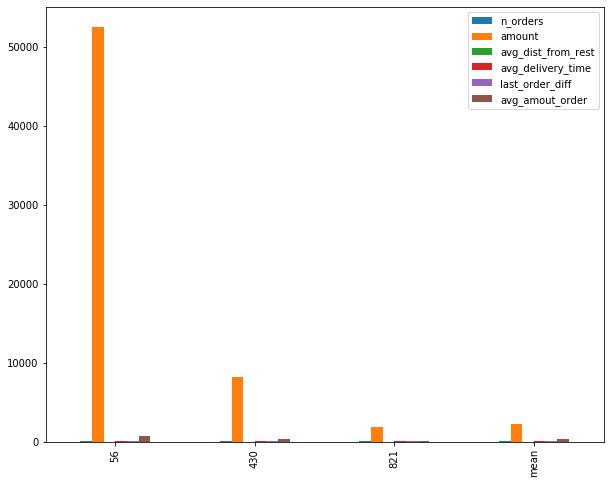

In [90]:
# getting means of columns
mean_data = data.describe().loc['mean', :]

# append the mean data to the samples
samples_bar = samples.append(mean_data)

print(samples_bar)

# construct indices
samples_bar.index = indices + ['mean']

# plot the bar plot
samples_bar.plot(kind='bar', figsize=(10,8))

### Feature Relevance

Let's see if the selected features are all independent or some of them are correlated and can be removed

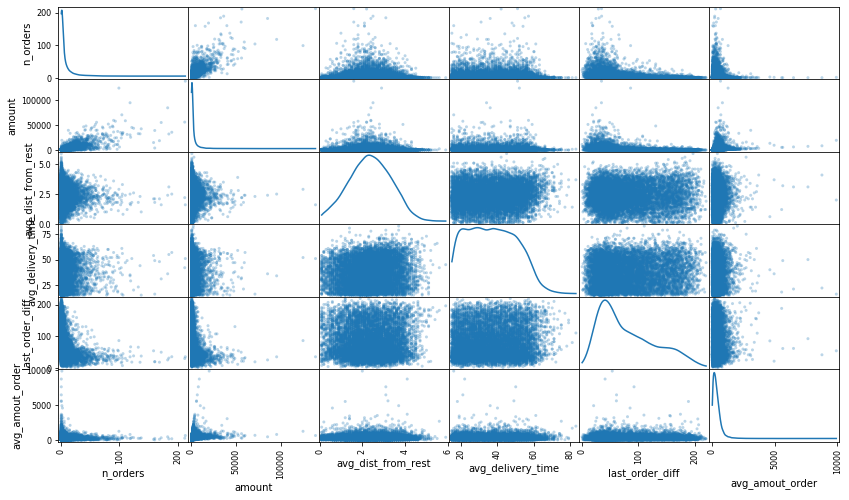

In [29]:
pd.plotting.scatter_matrix(data, alpha=0.3, figsize=(14,8), diagonal='kde');

Looking at the plot above, we can see that there is one pair that exhibits some level of correlation

- n_orders and amount

In [30]:
correlations_data = data.corr()['amount'].sort_values()
correlations_data

last_order_diff      -0.244546
avg_dist_from_rest   -0.016758
avg_delivery_time     0.002667
avg_amout_order       0.227655
n_orders              0.763239
amount                1.000000
Name: amount, dtype: float64

Again, we see that there is a high correlation value of 0.763239 between n_orders and amount. Let's check if it is possible to determine the value of amount using the rest of the features. We can easily determine this by training a supervised regression learner on the subset of features with the feature 'amount' removed, then score how well that model can predict **amount**.

In [91]:
# Make a copy of data for regression, by droping the amount column
reg_data = data.drop(['amount'], axis=1)

# Split data into training and test sets by using the given feature as target
X_train, X_test, y_train, y_test = train_test_split(reg_data, data['amount'], test_size=0.25, random_state=101)

# Create a decision tree regressor and fit it into the training set
regressor = DecisionTreeRegressor(random_state=101).fit(X_train,y_train)

# Find the prediction score using the testing set
score = regressor.score(X_test,y_test)

score

0.9674965350340035

The coefficient of determination, R^2 ranges between 0 and 1, with 1 being a perfect fit. While a negative R2 implies that the model fails to fit the data. R2 score for amount as dependent variable : 0.9674964992367574 Therefore, we can safely remove amount from the features as it can be predicted from other variables and hence is not an important feature independently.

In [92]:
model_data = reg_data

(5.0, 0.0)

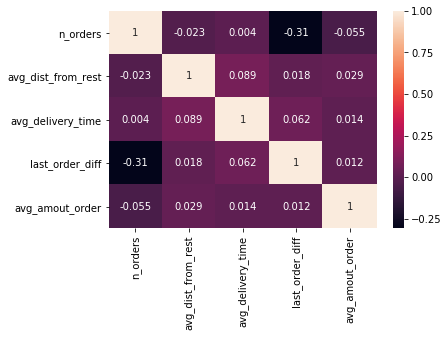

In [93]:
ax=sns.heatmap(model_data.corr() ,annot=True )
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

The results show that the features that we have finally selected are not much correlated with each other.

### Data Preprocessing


In [34]:
model_data.describe()

,n_orders,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
count,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000
mean,7.017939,2.363420,36.912508,79.838745,360.213554
std,13.130442,0.964743,13.176676,48.504703,373.361951
min,1.000000,0.100000,15.000000,0.754167,0.080000
25%,1.000000,1.700000,26.000000,40.720660,139.000000
50%,2.000000,2.400000,36.500000,66.291319,281.125000
75%,7.000000,3.100000,47.000000,112.435590,478.387500
max,212.000000,5.900000,83.000000,219.078472,9906.500000


From the mean and median values observed above, we can see that the data is quite skewed. Hence, we need to perform some feature scaling and remove outliers to get a better representation of the data and to ensure that the results obtained from the analysis are significant and meaningful.

### Feature Scaling

Text(0.5, 1.0, 'Order Number Histogram')

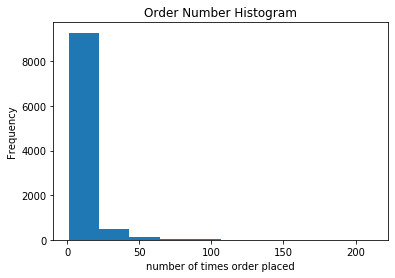

In [35]:
model_data['n_orders'].plot(kind='hist')
plot.xlabel('number of times order placed')
plot.title('Order Number Histogram')

Text(0.5, 1.0, 'Order Recency Histogram')

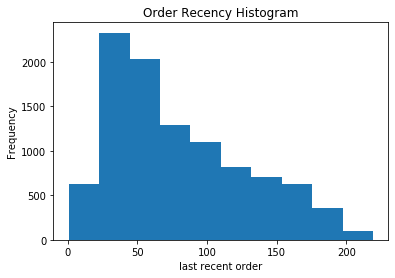

In [36]:
model_data['last_order_diff'].plot(kind='hist')
plot.xlabel('last recent order')
plot.title('Order Recency Histogram')

Text(0.5, 1.0, 'Average Amount  Histogram')

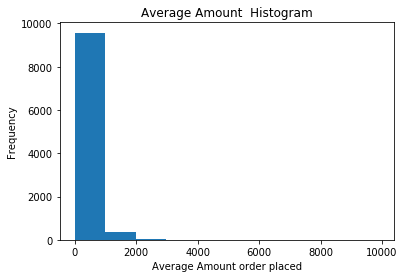

In [37]:
model_data['avg_amout_order'].plot(kind='hist')
plot.xlabel('Average Amount order placed')
plot.title('Average Amount  Histogram')

Since, for **avg_amount_per_order, n_orders and recency** are highly skewed distributions i.e. their mean and median of the features vary significantly, it is useful to apply some non-linear scaling. Natural logarithm is one method that can transform the dataset and bring it closer to normal distribution.

In [96]:
# Splitting data into two subsets, one subset will undergo log transform and the other will undergo standard scaling

skewed_features = model_data[['avg_amout_order', 'n_orders', 'last_order_diff']]
normal_features = model_data[['avg_dist_from_rest', 'avg_delivery_time']]

#### Scaling skewed features using natural logarithm

In [97]:
log_features = skewed_features.apply(lambda x: np.log(x+1))

#### Scaling normal features using Standard Scaler

In [40]:
from sklearn import preprocessing
normalized_features = pd.DataFrame(preprocessing.normalize(normal_features), columns=['avg_dist_from_rest', \
                                                                                      'avg_delivery_time'])
normalized_features.describe()

,avg_dist_from_rest,avg_delivery_time
count,9978.000000,9978.000000
mean,0.072845,0.996430
std,0.042435,0.004433
min,0.001852,0.952424
25%,0.043957,0.995716
50%,0.063508,0.997981
75%,0.092459,0.999033
max,0.304776,0.999998


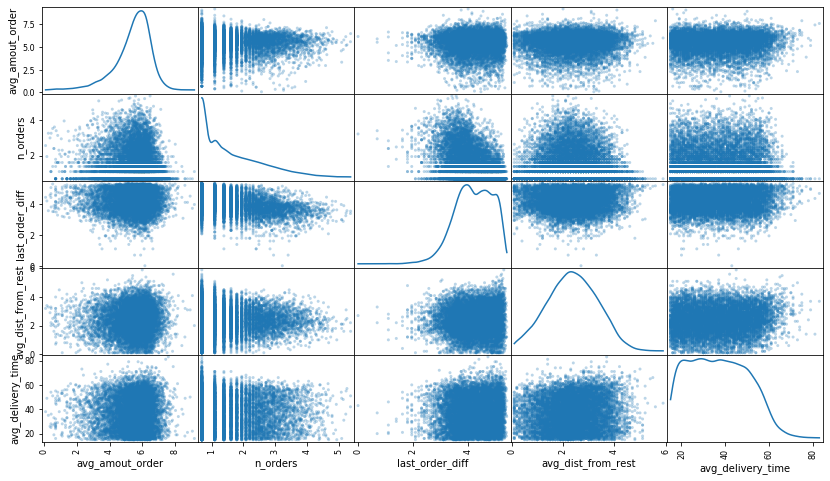

In [98]:
scaled_data = pd.concat([log_features, normal_features], axis=1)
pd.plotting.scatter_matrix(scaled_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

#### Scaling all the features using natural logarithm

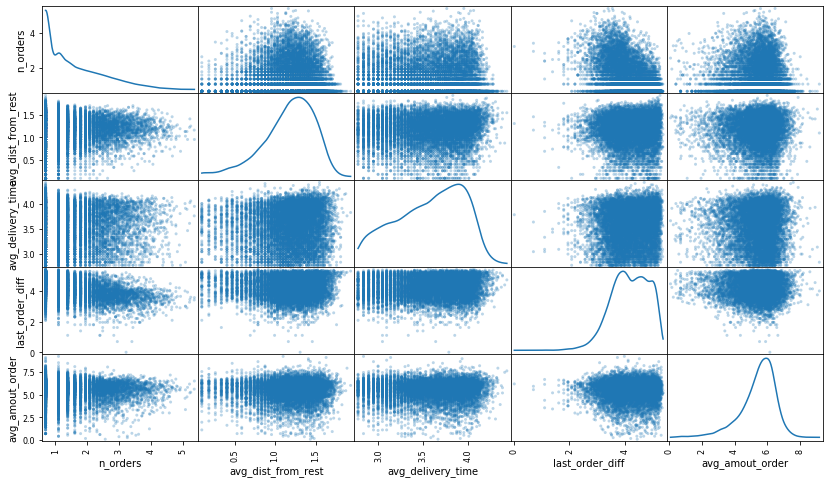

In [100]:
# scale the data using natural logarithm
log_data = model_data.apply(lambda x: np.log(x+1))

# scale the samples using natural logarithm
log_samples = samples.apply(lambda x: np.log(x+1))

# plot scatter matrix for each pair of newly-transformed data
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

After comparing both feature scaling techniques, we can observe that applying a natural logarithm scaling to the entire data transforms the distribution of each feature to become much more normal.

In [101]:
log_samples

,n_orders,amount,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
0,4.406719,10.867177,1.335001,3.526361,3.988984,6.474246
1,3.465736,9.015298,1.308333,4.043051,2.564949,5.584961
2,3.044522,7.530480,1.609438,3.871201,3.850148,4.544889


In [44]:
log_data.describe()

,n_orders,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
count,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000
mean,1.524216,1.166205,3.569698,4.192971,5.448126
std,0.919198,0.319251,0.371986,0.666487,1.085491
min,0.693147,0.095310,2.772589,0.561994,0.076961
25%,0.693147,0.993252,3.295837,3.730996,4.941642
50%,1.098612,1.223775,3.624252,4.209031,5.642350
75%,2.079442,1.410987,3.871201,4.731235,6.172509
max,5.361292,1.931521,4.430817,5.393984,9.201047


### Outlier Detection

Presence of outliers makes the dataset skewed which would in turn affect the results of the analysis. Here, we can use the **Turkey's Method** of identifying outliers, according to which an outlier is calculated as 1.5 times the interquartile range(IQR). A data point which is an outlier step outside of the IQR for that feature is considered an outlier.

In [45]:
outliers = []
for feature in log_data.keys():
    Q1= log_data.describe()[feature][4]
    Q3= log_data.describe()[feature][6]
    outlier_step = (Q3-Q1)*1.5
    out = log_data[~((log_data[feature] >= Q1 - outlier_step) & (log_data[feature] <= Q3 + outlier_step))]
    print('{} outlier range : [{} , {}]'.format(feature,Q1 - outlier_step,Q3 + outlier_step))
    print('{} outliers : {}'.format(feature,len(list(out.index.values))))
    outliers = outliers + list(out.index.values)
    display(out)
# creating list of outliers which are same across different features

outliers = list(set([x for x in outliers if outliers.count(x) > 1]))

n_orders outlier range : [-1.38629436111989 , 4.158883083359671]
n_orders outliers : 103


,n_orders,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
0,5.361292,0.955511,3.951244,3.580853,6.485780
1,5.356586,1.163151,3.761200,3.414031,5.592180
2,5.247024,1.252763,4.060443,3.587273,5.255305
3,5.220356,1.410987,4.025352,3.463498,5.179365
4,5.209486,1.223775,3.610918,3.259004,6.150304
...,...,...,...,...,...
98,4.174387,1.280934,4.094345,2.690395,4.669740
99,4.158883,1.098612,3.663562,3.588061,6.258606
100,4.158883,1.098612,3.988984,2.912275,5.432280
101,4.158883,0.693147,3.891820,3.224195,5.600309


avg_dist_from_rest outlier range : [0.36664897196031554 , 2.03758977476023]
avg_dist_from_rest outliers : 230


,n_orders,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
432,3.465736,0.262364,3.891820,3.978526,6.394677
479,3.401197,0.336472,3.931826,4.088413,6.285029
1116,2.833213,0.336472,3.610918,1.629241,6.002503
1126,2.833213,0.336472,3.610918,3.231024,6.381173
1392,2.639057,0.095310,3.465736,2.169847,4.479947
...,...,...,...,...,...
9807,0.693147,0.262364,3.135494,4.679034,7.225481
9842,0.693147,0.095310,3.433987,5.007464,5.273000
9874,0.693147,0.095310,3.737670,4.865069,5.303305
9924,0.693147,0.336472,3.091042,4.992594,5.257495


avg_delivery_time outlier range : [2.432790648648986 , 4.734247228263234]
avg_delivery_time outliers : 0


,n_orders,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order


last_order_diff outlier range : [2.2306383206650695 , 6.231593310431362]
last_order_diff outliers : 52


,n_orders,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
21,4.663439,1.252763,3.583519,2.092807,5.792190
270,3.737670,0.875469,2.772589,2.166272,5.678089
308,3.663562,1.435085,3.688879,1.978508,5.471514
321,3.637586,0.916291,3.583519,2.011192,6.046923
329,3.637586,0.788457,3.433987,2.070548,6.337834
364,3.583519,0.993252,3.931826,2.201383,5.075861
382,3.555348,1.481605,3.135494,2.222218,5.930280
406,3.496508,1.029619,3.988984,2.054302,4.963963
442,3.433987,1.098612,4.007333,1.665477,6.590205
481,3.401197,1.335001,3.218876,2.025861,3.772301


avg_amout_order outlier range : [3.0953422236731445 , 8.018809420836236]
avg_amout_order outliers : 393


,n_orders,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
32,4.574711,1.252763,3.970292,3.304110,2.967847
64,4.369448,1.435085,3.637586,3.169948,2.991724
118,4.094345,1.386294,4.043051,3.359483,3.031582
162,3.970292,0.832909,3.784190,3.942498,2.839078
167,3.951244,1.386294,2.890372,3.049865,2.860485
...,...,...,...,...,...
9823,0.693147,0.875469,3.135494,5.051168,1.791759
9844,0.693147,1.064711,2.833213,4.794108,2.484907
9855,0.693147,1.410987,3.091042,4.133198,8.777864
9898,0.693147,0.741937,3.988984,5.120013,2.772589


In [46]:
print("Outliers common across features: {}".format(outliers))

Outliers common across features: [32, 64, 2944, 9475, 9253, 1392, 9074, 6932, 21, 8308, 8469, 8283, 1116, 4574]


In [47]:
final_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)
label = label.drop(log_data.index[outliers]).reset_index(drop = True)
print("The final dataset now has {} observations after removing outliers.".format(len(final_data)))
final_data.describe()

The final dataset now has 9964 observations after removing outliers.


,n_orders,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
count,9964.000000,9964.000000,9964.000000,9964.000000,9964.000000
mean,1.523622,1.166638,3.569977,4.193767,5.448570
std,0.917919,0.318720,0.371953,0.665431,1.085350
min,0.693147,0.095310,2.772589,0.561994,0.076961
25%,0.693147,0.993252,3.295837,3.731662,4.941642
50%,1.098612,1.223775,3.637586,4.209140,5.642350
75%,2.079442,1.410987,3.871201,4.731381,6.172744
max,5.361292,1.931521,4.430817,5.393984,9.201047


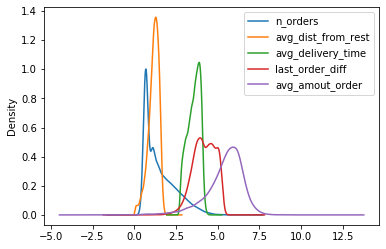

In [48]:
final_data.plot(kind='density')

### Feature Transformation

After feature scaling and outlier removal, we can now apply PCA to the transformed dataset to find which dimensions of the data best maximize the variance of the features. In addition to finding these dimensions, PCA will also report the explained variance ratio of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In [49]:
from sklearn.decomposition import PCA

pca = PCA().fit(final_data)

[0.43781208 0.36439939 0.10931487 0.05169488 0.03677878]
[0.43781208 0.80221147 0.91152634 0.96322122 1.        ]


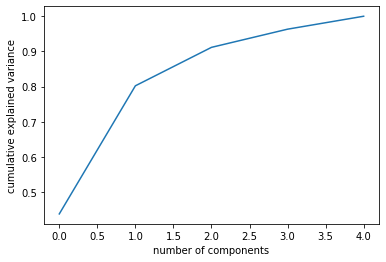

In [51]:
print(pca.explained_variance_ratio_) 
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
print(cum_var_exp)
plot.plot(cum_var_exp)
plot.xlabel('number of components')
plot.ylabel('cumulative explained variance')
plot.show()

The first and second feature explain approx. 80% of the variance in the data. The first 3 features, in total, explain approx 91% of the variance.

In [53]:
print(pca.components_)

[[ 0.15166128 -0.00624113 -0.00292374 -0.06103576 -0.98652217]
 [ 0.87398348  0.01038734 -0.00864093 -0.45773198  0.16263994]
 [-0.46111688 -0.009692   -0.05863586 -0.88520435 -0.01588664]
 [ 0.02141119 -0.22284452 -0.97301909  0.05566485  0.00414117]
 [ 0.00803258 -0.97473049  0.22296293 -0.00841145  0.00726103]]


### Dimensionality Reduction

In [55]:
# apply pca by fitting the final data with only two dimensions
pca = PCA(n_components=2).fit(final_data)

# transform the final data using the PCA fit
reduced_data = pca.transform(final_data)


In [56]:
reduced_data= pd.DataFrame(reduced_data,columns=['Dimension 1', 'Dimension 2'])
reduced_data.head()

,Dimension 1,Dimension 2
0,-0.403591,3.797815
1,0.486692,3.728526
2,0.790402,3.497027
3,0.867945,3.519972
4,-0.076695,3.763625


Text(0.5, 1.0, 'Reduced dimenshion')

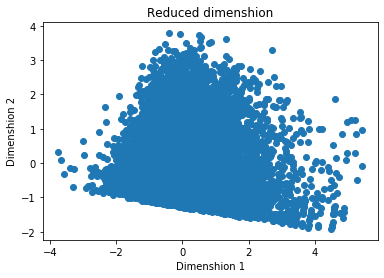

In [57]:
plot.scatter(reduced_data['Dimension 1'],reduced_data['Dimension 2'])
plot.xlabel('Dimenshion 1')
plot.ylabel('Dimenshion 2')
plot.title('Reduced dimenshion')

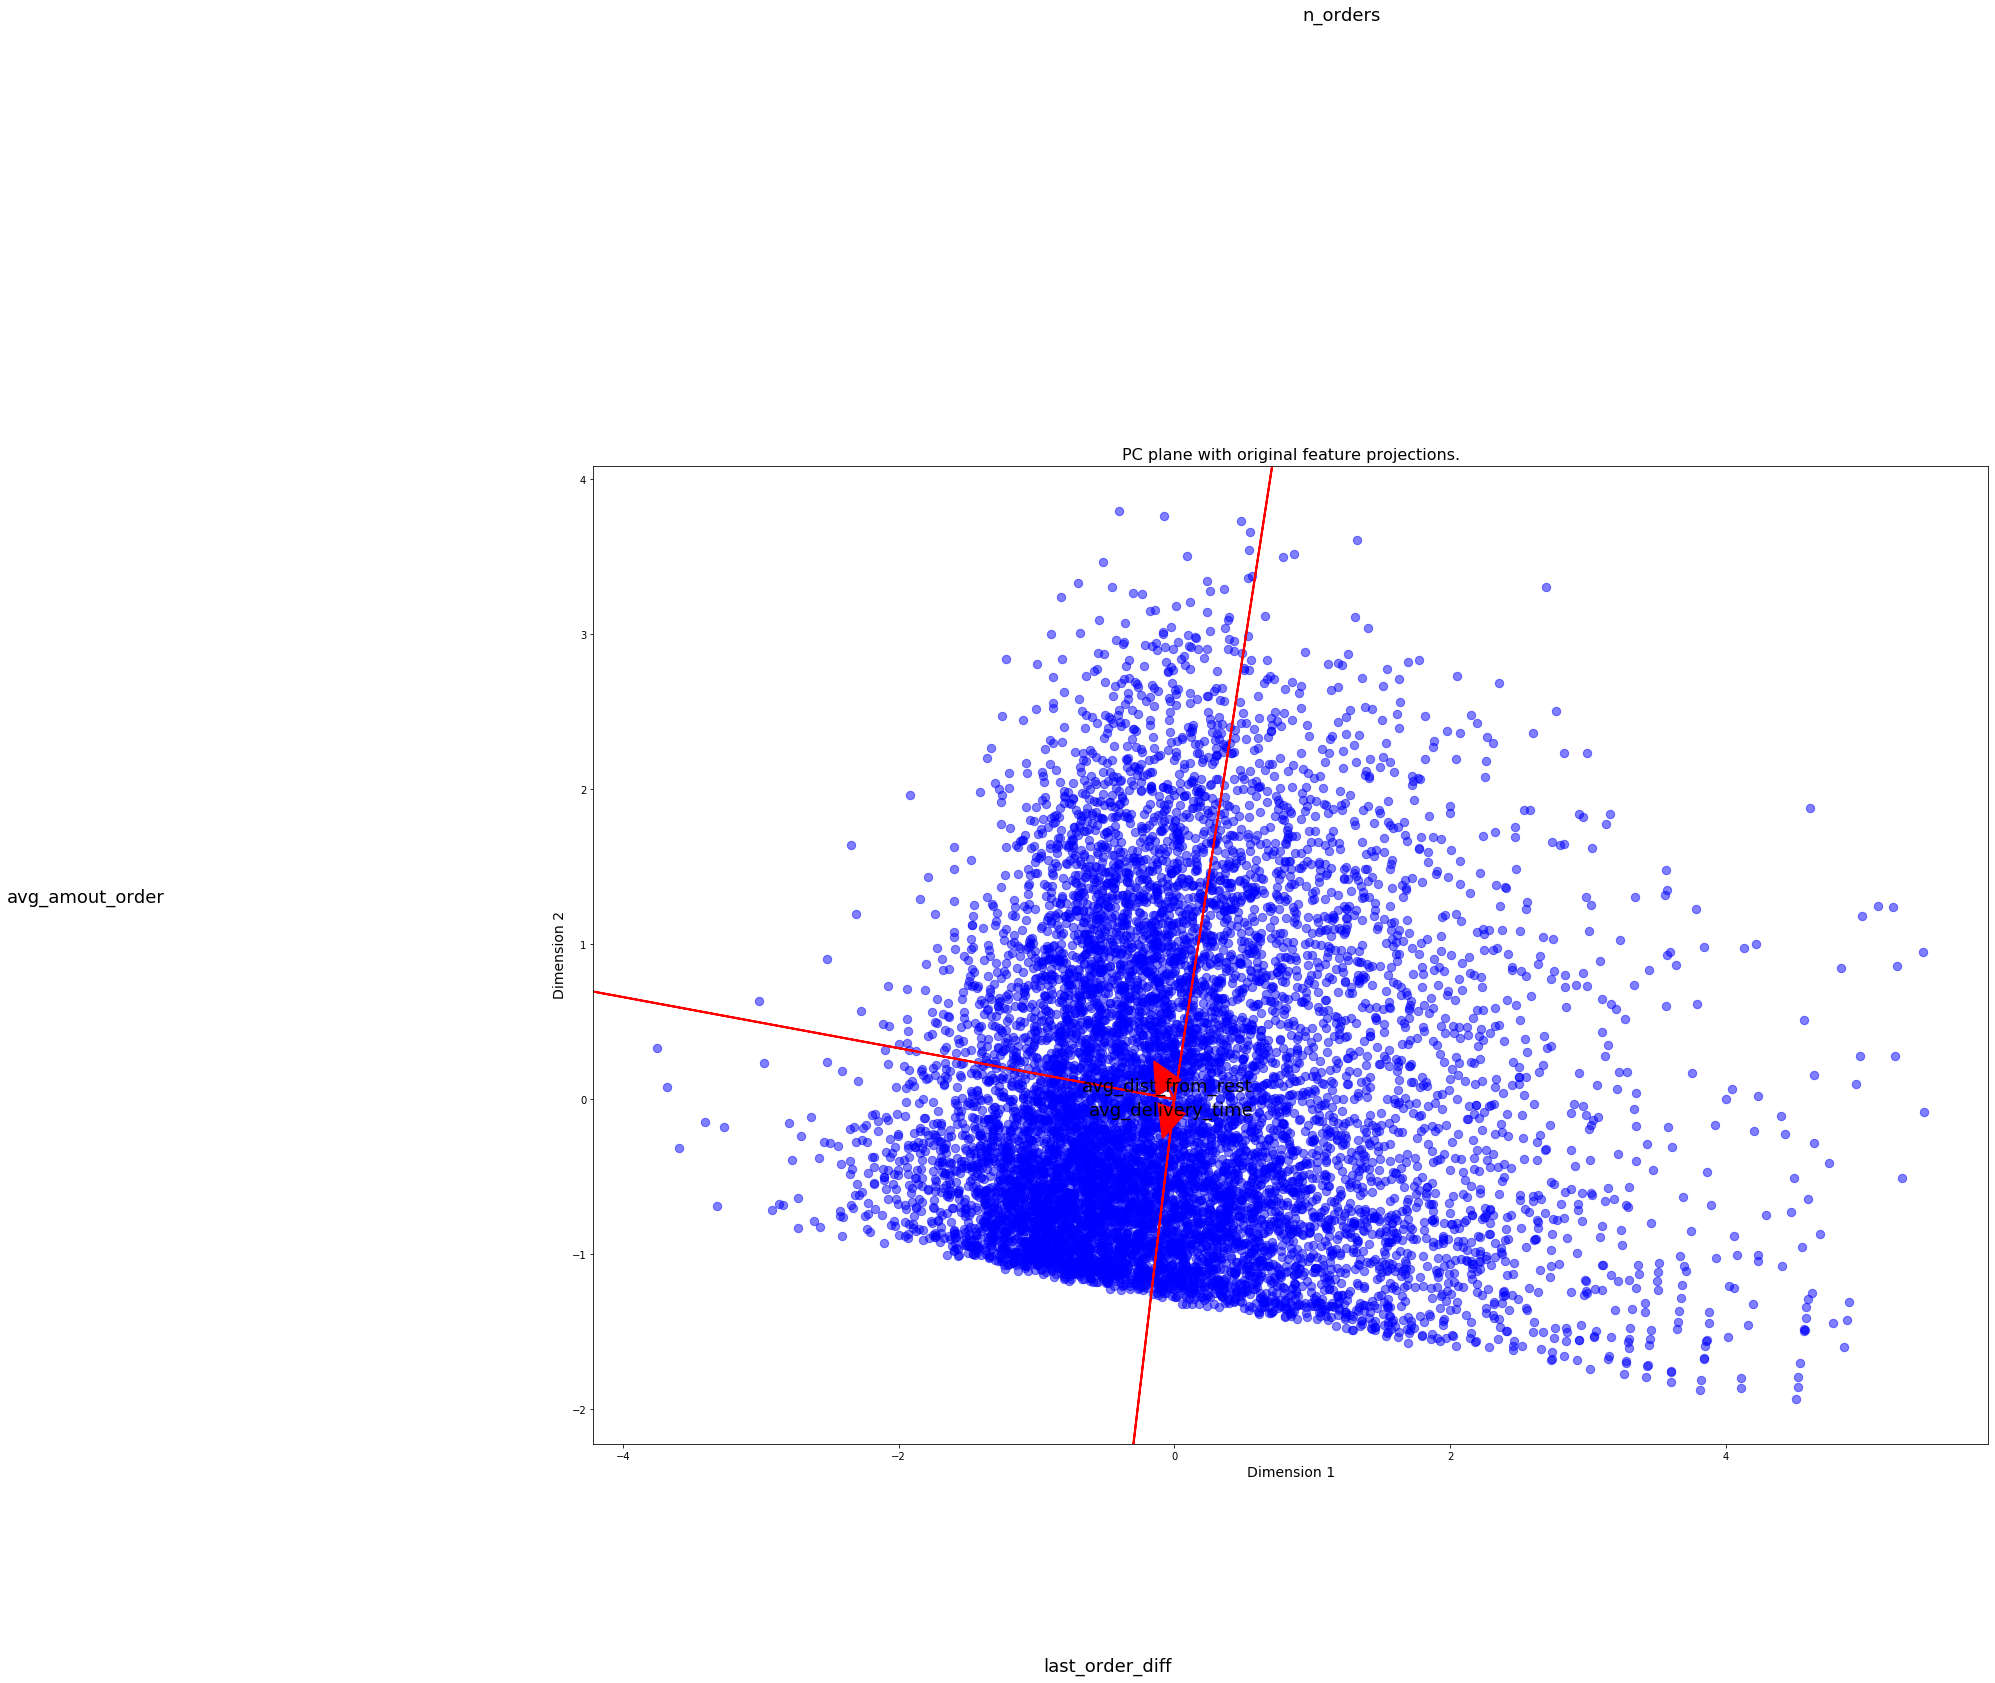

In [58]:
def biplot(final_data, reduced_data, pca):
    
    fig, ax = plot.subplots(figsize = (25,18))
    
    # scatterplot of the reduced data 
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # using scaling factors to make the arrows
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, final_data.columns[i], color='black', ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

biplot(final_data, reduced_data, pca)

### Clustering
Now, we will choose either ***K-means or GMM clustering algorithm*** to identify various customer segments in the data. Let's start with GMM.

In [59]:
n_clusters = list(range(2,11))

#### Gaussian Mixture Implementation

In [60]:
for n in n_clusters:
    clusterer = GaussianMixture(n_components=n).fit(reduced_data)
    preds = clusterer.predict(reduced_data)

    # cluster centers
    centers = clusterer.means_
    
    # calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='mahalanobis')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n, score))

For n_clusters = 2. The average silhouette_score is : 0.39172090754424155
For n_clusters = 3. The average silhouette_score is : 0.38763808826671997
For n_clusters = 4. The average silhouette_score is : 0.27823621653005126
For n_clusters = 5. The average silhouette_score is : 0.2840251096293084
For n_clusters = 6. The average silhouette_score is : 0.20920659665560376
For n_clusters = 7. The average silhouette_score is : 0.3295521004571641
For n_clusters = 8. The average silhouette_score is : 0.3293814379188835
For n_clusters = 9. The average silhouette_score is : 0.2099118270145289
For n_clusters = 10. The average silhouette_score is : 0.3265652554882689


#### KMeans Implementation

In [61]:
for n in n_clusters:
    clustererK = KMeans(n_clusters=n).fit(reduced_data)

    # predict the cluster for each data point
    preds = clustererK.predict(reduced_data)

    # find the cluster centers
    centers = clustererK.cluster_centers_

    # predict the cluster for each transformed sample data point
    #sample_preds = clusterer.predict(pca_samples)

    # calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print("For n_clusters = {}. The average silhouette_score is : {}".format(n, score))


For n_clusters = 2. The average silhouette_score is : 0.3682900602350955
For n_clusters = 3. The average silhouette_score is : 0.4250356615315836
For n_clusters = 4. The average silhouette_score is : 0.3682094961762671
For n_clusters = 5. The average silhouette_score is : 0.3587044819662621
For n_clusters = 6. The average silhouette_score is : 0.36495178707079673
For n_clusters = 7. The average silhouette_score is : 0.3370406564819825
For n_clusters = 8. The average silhouette_score is : 0.33924976683910446
For n_clusters = 9. The average silhouette_score is : 0.33165857823421485
For n_clusters = 10. The average silhouette_score is : 0.33370521195653347


#### Best score is obtained for 3 clusters by both methods.

### Clusters

In [62]:
# Extra code because we ran a loop on top and this resets to what we want
clusterer = GaussianMixture(n_components=3).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
print(centers)
clustererK = KMeans(n_clusters=3).fit(reduced_data)
preds = clustererK.predict(reduced_data)
centers = clustererK.cluster_centers_
print(centers)

[[-0.36932331 -0.66916036]
 [-0.18246879  0.86649011]
 [ 1.4203159  -0.10699655]]
[[-0.59420647 -0.48084994]
 [ 0.03426415  1.30914201]
 [ 1.58853238 -0.54167632]]


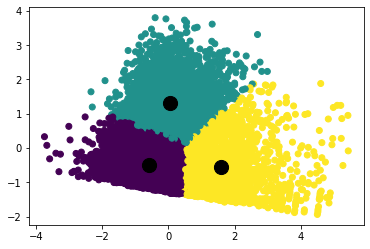

In [63]:
plot.scatter(reduced_data['Dimension 1'], reduced_data['Dimension 2'], c=clustererK.labels_, cmap='viridis')  
plot.scatter(centers[:,0], centers[:, 1], c='black', s=200, alpha=1);

### Data Recovery

In [64]:
# take inverse transform of the centers
log_centers = pca.inverse_transform(centers)

# take exponential of the centers
true_centers = np.exp(log_centers)

# display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = model_data.keys())
true_centers.index = segments
display(true_centers)

,n_orders,avg_dist_from_rest,avg_delivery_time,last_order_diff,avg_amout_order
Segment 0,3.0,3.0,36.0,86.0,386.0
Segment 1,14.0,3.0,35.0,36.0,278.0
Segment 2,4.0,3.0,36.0,77.0,44.0


Let's take a guess about the characteristics of the customers belonging to each segments

- **Segment 0**: This segment belongs to the customers that order frequently (make atleast 1 order per month), have been most active on the app and spend a decent amount on the order. Reason could also be that they are closest to the restaurants.

- **Segment 1**: This segment belongs to the customers that are not as frequent and do not use the app frequenctly (have not been active since past 3 months), but in the past have made orders with sufficient amount.

- **Segment 2**: This segment belongs to the customers that neither very frequent or spend enough on orders. They have also lost touch with the app.

### Conclusions and Implications

So, how can this knowledge be used to improve the user experience or bring back customers on the app

So the company can run send push notification to customers belonging to segment 1 who were active big spenders before but have lost touch now. For the customers in segment 0, the customers can provide some offers/free delivery charges to make them more active on the app. For customers in segment 2, the company ca provide some discounts and combo offers which can motivate them to use the platform again.

